In [1]:
from fullfrlm import flow_refueling_location_model
from generate_network import generate_network
from flow_computation import flow_computation
from random_vessel_generator import random_vessel_generator
from first_stage_frlm import first_stage_frlm
from second_stage_frlm import second_stage_frlm
from create_input_data_abm import create_input_data_abm
from visualize_placement import visualize_placement
import pickle
from determine_additional_nodes import determine_additional_nodes
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time


Optimal


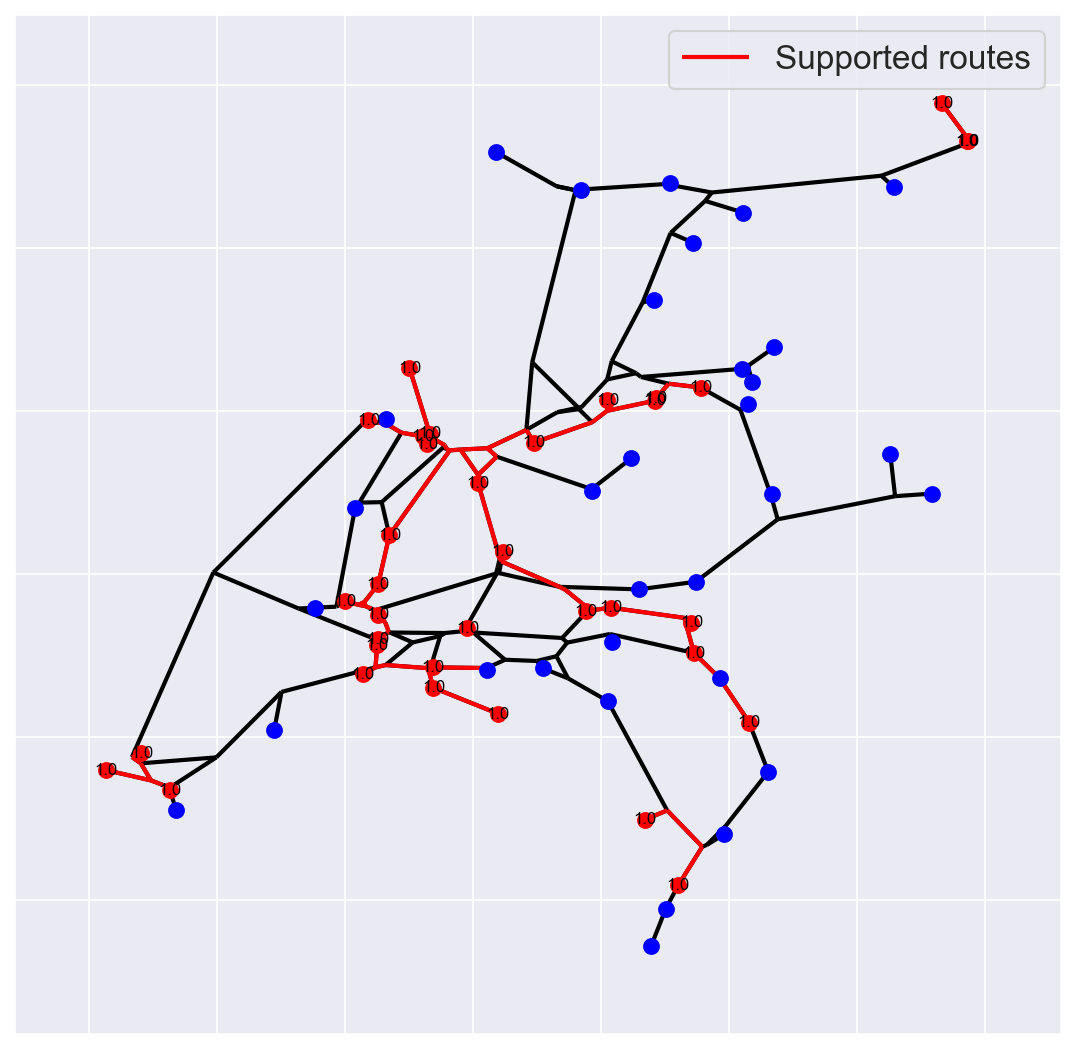

In [2]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, \
                non_zero_flows, routes_supported, paths, G, df_abm, df_random = flow_refueling_location_model(1, 50000, 40, 1000, True, include_intersections=True, vis=True)

In [40]:
%%time
dict_30it = {'total_flow':[], 'fraction_captured_total':[]}
## Test full frlm
for i in range(30):
        total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, \
                non_zero_flows, routes_supported, paths, G, df_abm, df_random = flow_refueling_location_model(1, 100000, 40, 1000, 2, 0, include_intersections=False, vis=False)
        dict_30it['total_flow'].append(total_flow)
        dict_30it['fraction_captured_total'].append(fraction_captured_total)

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
CPU times: total: 5min 14s
Wall time: 5min 34s


In [43]:
df1 = pd.DataFrame.from_dict(dict_30it)

In [45]:
df1.describe()

,total_flow,fraction_captured_total
count,60.000000,60.000000
mean,1259.061239,0.292421
std,2.155010,0.050798
min,1254.063796,0.238722
25%,1257.796419,0.242296
50%,1258.983679,0.291502
75%,1260.077339,0.342790
max,1265.619491,0.345997


In [41]:
%%time
dict_30it2 = {'total_flow':[], 'fraction_captured_total':[]}
## Test full frlm
for i in range(30):
        total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, \
                non_zero_flows, routes_supported, paths, G, df_abm, df_random = flow_refueling_location_model(1, 50000, 40, 1000, 2, 0, include_intersections=False, vis=False)
        dict_30it['total_flow'].append(total_flow)
        dict_30it['fraction_captured_total'].append(fraction_captured_total)

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
CPU times: total: 2min 45s
Wall time: 2min 48s


In [3]:
fraction_captured_total

0.18769414604124574

In [4]:
serveable_fraction

0.26332231817106594

In [5]:
served_fraction

0.71279239581702

In [6]:
sum(optimal_facilities.values())

36.0

## Load necessary data

In [13]:
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

In [14]:
df_ivs

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B04,M0,C2l,BII-2L,B02,C1b,C2b,B01,C1l,route_v
0,NLRTM,NLAMS,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NLRTM,NLAMS,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NLRTM,NLAMS,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NLRTM,NLAMS,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NLRTM,NLAMS,6,4,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,NLAMS,NLZWI,1,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3908,NLAMS,NLZWI,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3909,NLAMS,NLZWI,0,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3910,NLAMS,NLZWI,1,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


## Generate random df

In [36]:
%%time
df_chance = df_ivs.copy()
df_random1 = random_vessel_generator(df_chance, 1)

CPU times: total: 3.12 s
Wall time: 3.31 s


In [37]:
df_random1

,origin,destination,trip_count,hour,M12,M8,BII-6b,M10,BIIa-1,M9,...,B04,M0,C2l,BII-2L,B02,C1b,C2b,B01,C1l,route_v
0,NLRTM,NLAMS,174,0,0,121,0,0,1,38,...,0,0,0,0,0,0,0,0,0,1
1,NLRTM,NLAMS,152,0,98,0,0,12,0,0,...,0,0,0,1,0,0,0,0,0,2
2,NLRTM,NLMOE,57,0,0,42,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
3,NLRTM,NLMOE,31,0,2,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
4,NLRTM,NLVLI,85,0,10,21,0,5,0,24,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,NLHTB,NLBON,1,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2851,NLRTM,NLLID,2,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2852,NLRTM,NLSLU,25,23,0,22,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2853,NLRTM,NLSLU,1,23,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1



## Compute path flows

In [38]:
%%time
flows = flow_computation(df_random1)

CPU times: total: 250 ms
Wall time: 242 ms


In [39]:
sum(flows.values())

1260.46277886497

## Generate network

In [19]:
%%time
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))
G, paths, inserted_nodes = generate_network(G, paths, 30)

30 nodes were inserted
CPU times: total: 719 ms
Wall time: 708 ms


In [20]:
inserted = determine_additional_nodes(G, df_h, 30)

In [21]:
inserted

['8867785',
 '8864435',
 '8860579',
 '8860918',
 '8862419',
 '8862690',
 '8863114',
 '8862801',
 '8862813',
 '8860804',
 '106',
 '8865143',
 '117',
 '118',
 '8862907',
 '8867824',
 '8861611',
 '108',
 '8862340',
 '112',
 '127',
 '126',
 '8860563',
 '8862851',
 '114',
 '8860623',
 '8864915',
 '121',
 '103',
 '8865462']

In [22]:
%%time
# range r in meters
df_b, df_g, df_eq_fq, feasible_combinations = first_stage_frlm(100000, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h, additional_nodes=inserted)

CPU times: total: 4.56 s
Wall time: 4.57 s


## Run second stage FRLM

In [23]:
%%time
optimal_facilities, optimal_flows, non_zero_flows, supported_flow, routes_supported = second_stage_frlm(100000, 15000, 175, 40, 2500, 2, df_g, df_b, df_eq_fq)

Optimal
CPU times: total: 26 s
Wall time: 28.6 s


In [24]:
optimal_facilities

{'103': 2.0,
 '106': 0.0,
 '108': 0.0,
 '112': 1.0,
 '114': 0.0,
 '117': 0.0,
 '118': 0.0,
 '121': 0.0,
 '126': 0.0,
 '127': 0.0,
 '22637863': 0.0,
 '22638146': 1.0,
 '22638156': 0.0,
 '22638320': 0.0,
 '22638327': 0.0,
 '30984595': 2.0,
 '8860563': 0.0,
 '8860579': 0.0,
 '8860623': 1.0,
 '8860804': 0.0,
 '8860918': 0.0,
 '8861305': 0.0,
 '8861462': 0.0,
 '8861528': 0.0,
 '8861611': 0.0,
 '8861625': 0.0,
 '8861718': 0.0,
 '8862085': 0.0,
 '8862340': 0.0,
 '8862419': 0.0,
 '8862497': 0.0,
 '8862506': 0.0,
 '8862570': 0.0,
 '8862663': 2.0,
 '8862690': 1.0,
 '8862801': 1.0,
 '8862813': 2.0,
 '8862851': 0.0,
 '8862907': 0.0,
 '8863019': 1.0,
 '8863114': 0.0,
 '8863125': 0.0,
 '8863152': 0.0,
 '8863207': 0.0,
 '8863260': 1.0,
 '8863306': 2.0,
 '8863360': 2.0,
 '8863408': 0.0,
 '8863469': 1.0,
 '8863518': 0.0,
 '8863614': 0.0,
 '8863709': 0.0,
 '8863818': 0.0,
 '8863861': 0.0,
 '8863966': 0.0,
 '8864005': 1.0,
 '8864018': 0.0,
 '8864111': 1.0,
 '8864153': 0.0,
 '8864435': 0.0,
 '8864494': 0.

In [25]:
sum(optimal_facilities.values())

40.0

In [26]:
sum(optimal_flows.values())

77.87139866000001

In [27]:
supported_flow

656.4778474271045

## Create input data ABM

In [28]:
%%time
df_abm = create_input_data_abm(G, paths, non_zero_flows, optimal_facilities)

CPU times: total: 281 ms
Wall time: 287 ms


In [29]:
df_abm

,id,source,target,length_m,X,Y,name,charging_stations,model_type
0,10000,30986055,8867600,8380.518917,5.365231,53.183419,"(30986055, 8867600)",NaN,link
1,10001,30986055,8865756,2481.139176,5.412350,53.178500,"(30986055, 8865756)",NaN,link
2,10002,11309058,8865990,18936.187403,5.450226,51.645417,"(11309058, 8865990)",NaN,link
3,10003,11309058,8866775,11560.215727,5.324146,51.695530,"(11309058, 8866775)",NaN,link
4,10004,11309058,11309119,9235.019525,5.349926,51.714149,"(11309058, 11309119)",NaN,link
...,...,...,...,...,...,...,...,...,...
284,10284,NaN,NaN,NaN,5.494287,51.957078,124,0.0,inserted_node
285,10285,NaN,NaN,NaN,4.764483,52.304545,125,0.0,inserted_node
286,10286,NaN,NaN,NaN,5.682730,51.881516,130,0.0,inserted_node
287,10287,NaN,NaN,NaN,4.792471,52.531953,131,0.0,inserted_node


## Visualize placement

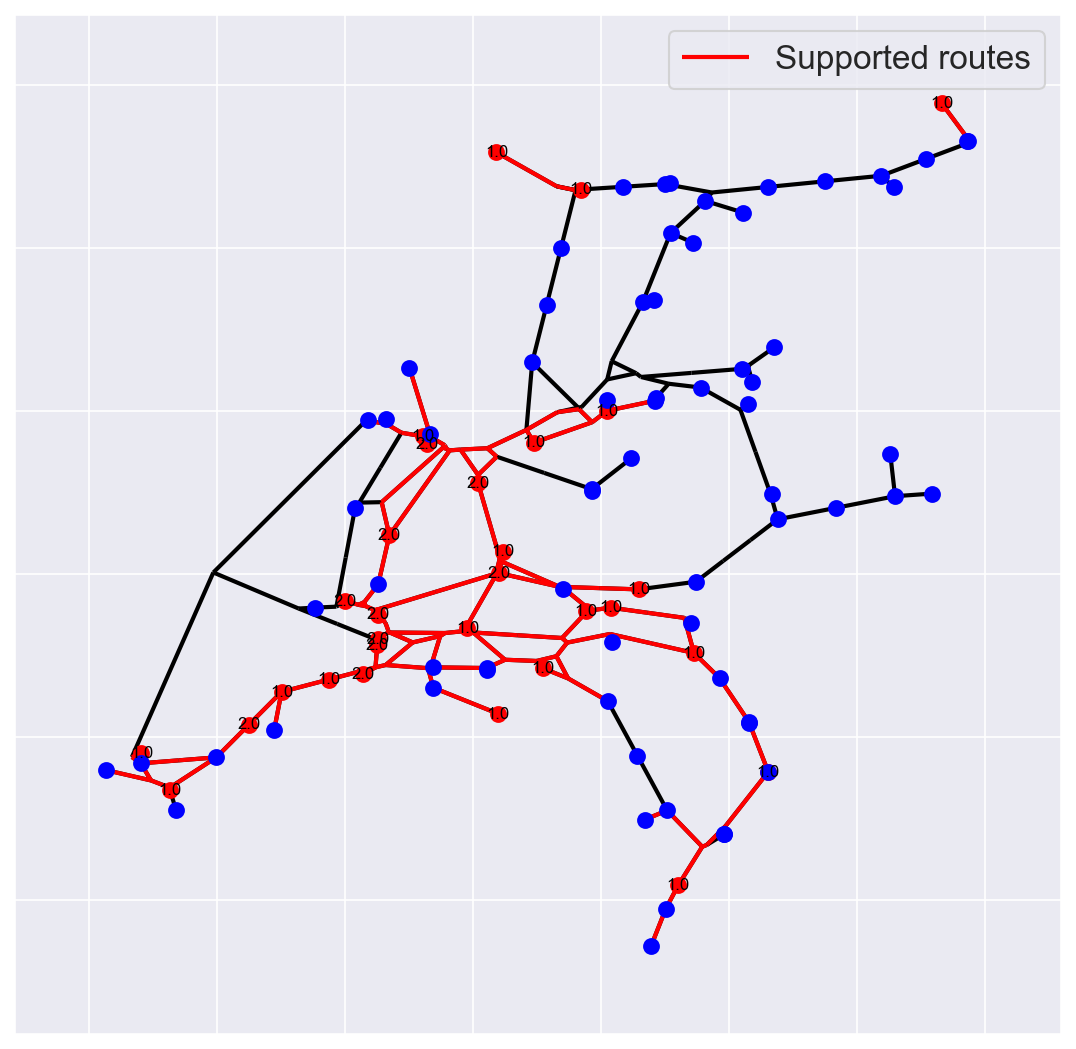

In [30]:
visualize_placement(G,flows, optimal_facilities, non_zero_flows, df_h, paths, True)